<a href="https://colab.research.google.com/github/shambhavisud/CLI-QUIZ-APP-KNOW-ME/blob/master/attention_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -U future

In [1]:
import os, sys
import keras.backend as K
from keras.models import Model
from __future__ import print_function, division
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
import numpy as np
from builtins import range, input
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.layers import Embedding





In [2]:
try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

In [3]:
def ot_soft_max(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s

In [4]:
n_size_batch = 64
dim_latent_decoder = 400 
nepochs = 30
num_wrds_max = 20000
dim_latent = 400
dim_embedding = 100
samples_num = 20000

In [5]:
sentences_inputs = [] #INITIAL LANGUAGE SENTENTCES
sentences_outputs = [] # LANGUAGE SENTNCES IN TARGETTED LANG
sentences_outputs_inputs = [] #offset by1f targ lang


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
b = 0
for line in open('/content/drive/My Drive/translation_files/hin.txt'):

  b += 1
  if b > samples_num:
    break


  if '\t' not in line:
    continue

  sentences_input, translation, *rest = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  sentences_output = translation + ' <eos>'
  sentences_output_input = '<sos> ' + translation

  sentences_inputs.append(sentences_input)
  sentences_outputs.append(sentences_output)
  sentences_outputs_inputs.append(sentences_output_input)
print("num samples:", len(sentences_inputs))

num samples: 2952


In [9]:

ips_toknisr = Tokenizer(num_words=num_wrds_max)
ips_toknisr.fit_on_texts(sentences_inputs)
seqs_ip = ips_toknisr.texts_to_sequences(sentences_inputs)


inputs_w2ind = ips_toknisr.word_index
print(' %s different i/p tokens were found.' % len(inputs_w2ind))

ip_mx_lnth = max(len(i) for i in seqs_ip)


op_tokniser = Tokenizer(num_words=num_wrds_max, filters='')
op_tokniser.fit_on_texts(sentences_outputs + sentences_outputs_inputs) # inefficient, oh well
target_sequences = op_tokniser.texts_to_sequences(sentences_outputs)
ip_target_seqs = op_tokniser.texts_to_sequences(sentences_outputs_inputs)

outputs_w2ind = op_tokniser.word_index
print(' %s different output tokens we re foun d' % len(outputs_w2ind))

op_num_wrds = len(outputs_w2ind) + 1


trgt_lenth_mx = max(len(sn) for sn in target_sequences)

 2429 different i/p tokens were found.
 3195 different output tokens we re foun d


In [10]:
ip_encdr = pad_sequences(seqs_ip, maxlen=ip_mx_lnth)
print("encoder_data.shape:", ip_encdr.shape)
print("encoder_data[0]:", ip_encdr[0])

ip_dcdr = pad_sequences(ip_target_seqs, maxlen=trgt_lenth_mx, padding='post')
print("decoder_data[0]:", ip_dcdr[0])
print("decoder_data.shape:", ip_dcdr.shape)

trgt_dcdrs = pad_sequences(target_sequences, maxlen=trgt_lenth_mx, padding='post')

encoder_data.shape: (2952, 22)
encoder_data[0]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 1305]
decoder_data[0]: [   2 1521    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
decoder_data.shape: (2952, 26)


In [11]:

print('uploading word vectors   ')
wrd_to_vec = {}
with open(os.path.join('/content/drive/My Drive/translation_files/glove.6B.%sd.txt' % dim_embedding)) as o:
 
  for line in o:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    wrd_to_vec[word] = vec
print('%s word vectors were found' % len(wrd_to_vec))

uploading word vectors   
400000 word vectors were found


In [12]:
print('Filling pre-trained embeddings...')
num_words = min(num_wrds_max, len(inputs_w2ind) + 1)
embedding_matrix = np.zeros((num_words, dim_embedding))
for word, i in inputs_w2ind.items():
  if i < num_wrds_max:
    embedding_vector = wrd_to_vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [13]:
# for embedding layer creation
embedding_layer = Embedding(
  num_words,
  dim_embedding,
  weights=[embedding_matrix],
  input_length=ip_mx_lnth,
  
)


In [14]:
trgt_dcdrs1_hot = np.zeros(
  (
    len(sentences_inputs),
    trgt_lenth_mx,
    op_num_wrds
  ),
  dtype='float32'
)

# initialize
for i, d in enumerate(trgt_dcdrs):
  for t, word in enumerate(d):
    if word > 0:
      trgt_dcdrs1_hot[i, t, word] = 1


In [15]:

ip_encdr_plshldr = Input(shape=(ip_mx_lnth,))
x = embedding_layer(ip_encdr_plshldr)
encoder = Bidirectional(LSTM(
  dim_latent,
  return_sequences=True,

))
encoder_outputs = encoder(x)


ip_dcdr_plshldr = Input(shape=(trgt_lenth_mx,))


decoder_embedding = Embedding(op_num_wrds, dim_embedding)
ip_dcdr_x = decoder_embedding(ip_dcdr_plshldr)


In [16]:

layr_attention_rep = RepeatVector(ip_mx_lnth)
layr_attention_concatenatn = Concatenate(axis=-1)
dense_attention_1 = Dense(10, activation='tanh')
dense_attention_2 = Dense(1, activation=ot_soft_max)
attn_dot = Dot(axes=1) 
def one_step_attention(h, st_1):
 
 

  st_1 = layr_attention_rep(st_1)

 
  x = layr_attention_concatenatn([h, st_1])

  x = dense_attention_1(x)

  
  alphas = dense_attention_2(x)

  
  context = attn_dot([alphas, h])

  return context

In [17]:
lstm_dcdr = LSTM(dim_latent_decoder, return_state=True)
dense_dcdr = Dense(op_num_wrds, activation='softmax')

s_init = Input(shape=(dim_latent_decoder,), name='s0')
c_init = Input(shape=(dim_latent_decoder,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)





s = s_init
c = c_init


outputs = []
for t in range(trgt_lenth_mx): 
  context = one_step_attention(encoder_outputs, s)

  
  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(ip_dcdr_x)
  

  ip_lstm_dcdr = context_last_word_concat_layer([context, xt])

  
  o, s, c = lstm_dcdr(ip_lstm_dcdr, initial_state=[s, c])

 
  op_dcdr = dense_dcdr(o)
  outputs.append(op_dcdr)


In [18]:
def trnspoz_stack(x):
  
  x = K.stack(x) 
  x = K.permute_dimensions(x, pattern=(1, 0, 2)) 
  return x


In [19]:

stacker = Lambda(trnspoz_stack)
outputs = stacker(outputs)


model = Model(
  inputs=[
    ip_encdr_plshldr,
    ip_dcdr_plshldr,
    s_init, 
    c_init,
  ],
  outputs=outputs
)


In [20]:
def custom_loss(y_true, y_pred):
  
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
  
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

 
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  crct_n = K.sum(mask * correct)
  totl_n = K.sum(mask)
  return crct_n / totl_n


In [22]:

model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])



z = np.zeros((len(ip_encdr), dim_latent_decoder)) 
r = model.fit(
  [ip_encdr, ip_dcdr, z, z], trgt_dcdrs1_hot,
  batch_size=n_size_batch,
  epochs=nepochs,
  validation_split=0.2
)






Epoch 1/30
37/37 [==============================] - 77s 645ms/step - loss: 3.8280 - acc: 0.2726 - val_loss: 6.5626 - val_acc: 0.1222
Epoch 2/30
37/37 [==============================] - 10s 266ms/step - loss: 3.4929 - acc: 0.2936 - val_loss: 6.7410 - val_acc: 0.1220
Epoch 3/30
37/37 [==============================] - 10s 270ms/step - loss: 3.3105 - acc: 0.3086 - val_loss: 6.9181 - val_acc: 0.1216
Epoch 4/30
37/37 [==============================] - 10s 269ms/step - loss: 3.1477 - acc: 0.3264 - val_loss: 7.0439 - val_acc: 0.1167
Epoch 5/30
37/37 [==============================] - 10s 259ms/step - loss: 3.0040 - acc: 0.3443 - val_loss: 7.1107 - val_acc: 0.1177
Epoch 6/30
37/37 [==============================] - 10s 260ms/step - loss: 2.8503 - acc: 0.3646 - val_loss: 7.2734 - val_acc: 0.1243
Epoch 7/30
37/37 [==============================] - 10s 261ms/step - loss: 2.7029 - acc: 0.3982 - val_loss: 7.3128 - val_acc: 0.1181
Epoch 8/30
37/37 [==============================] - 10s 264ms/step - 

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 22)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 22, 100)      243000      ['input_1[0][0]']                
                                                                                                  
 s0 (InputLayer)                [(None, 400)]        0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 22, 800)      1603200     ['embedding[0][0]']              
                                                                                              

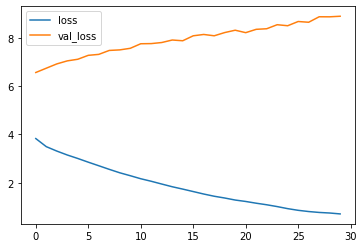

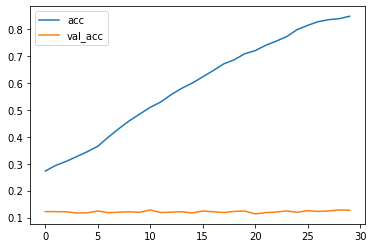

In [24]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()


encoder_model = Model(ip_encdr_plshldr, encoder_outputs)

# T=1 decoder modl definition
encoder_outputs_as_input = Input(shape=(ip_mx_lnth, dim_latent * 2,))
single_ip_dcdr = Input(shape=(1,))
single_ip_dcdr_x = decoder_embedding(single_ip_dcdr)


context = one_step_attention(encoder_outputs_as_input, s_init)

# last word & context combo
ip_lstm_dcdr = context_last_word_concat_layer([context, single_ip_dcdr_x])




# finl dense & lmst
o, s, c = lstm_dcdr(ip_lstm_dcdr, initial_state=[s_init, c_init])
op_dcdr = dense_dcdr(o)





# model object creation
decoder_model = Model(
  inputs=[
    single_ip_dcdr,
    encoder_outputs_as_input,
    s_init, 
    c_init
  ],
  outputs=[op_dcdr, s, c]
)



# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in inputs_w2ind.items()}
idx2word_trans = {v:k for k, v in outputs_w2ind.items()}





def decode_sequence(input_seq):
  
  enc_out = encoder_model.predict(input_seq)

  
  target_seq = np.zeros((1, 1))
  
  
  target_seq[0, 0] = outputs_w2ind['<sos>']

  
  eos = outputs_w2ind['<eos>']


  
  s = np.zeros((1, dim_latent_decoder))
  c = np.zeros((1, dim_latent_decoder))


  
  output_sentence = []
  for _ in range(trgt_lenth_mx):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        

    
    idx = np.argmax(o.flatten())

    
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    
    target_seq[0, 0] = idx

  return ' '.join(output_sentence)


In [25]:
while True:
  # Do some test translations
  i = np.random.choice(len(sentences_inputs))
  input_seq = ip_encdr[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', sentences_inputs[i])
  print('Predicted translation:', translation)
  print('Actual translation:', sentences_outputs[i])

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input sentence: What is done cannot be undone.
Predicted translation: होनी को अनहोनी है सो जा सकता। है।
Actual translation: होनी को अनहोनी नहीं किया जा सकता। <eos>
Continue? [Y/n]y
-
Input sentence: She leaped for joy.
Predicted translation: वह खुशी से उछल पड़ी।
Actual translation: वह खुशी से उछल पड़ी। <eos>
Continue? [Y/n]y
-
Input sentence: Don't make fun of them.
Predicted translation: उनका मज़ाक मत उड़ाओ।
Actual translation: उनका मज़ाक मत उड़ाओ। <eos>
Continue? [Y/n]y
-
Input sentence: My father went jogging after dinner.
Predicted translation: मेरे पापा रात को को खाने बाद बाद दौड़ने गए थे।
Actual translation: मेरे पापा रात को खाना खाने के बाद दौड़ने गए थे। <eos>
Continue? [Y/n]y
-
Input sentence: These dogs are big.
Predicted translation: ये कुत्ते बड़े हैं।
Actual translation: ये कुत्ते बड़े हैं। <eos>
Continue? [Y/n]y
-
Input sentence: The king abused his power.
Predicted translation: राजा ने अपनी ताकत का दुरुपयोग किया।
Actual translation: राजा ने अपनी ताकत का दुरुपयोग किया। <